In [5]:
!pip install jupyter_beeper 
!pip install livelossplot


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## here you have changes

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py # Read and write HDF5 files from Python
import tensorflow as tf
from scipy.signal import welch, stft
import matplotlib.pyplot as plt
import matplotlib
import time
from livelossplot import PlotLossesKeras
import jupyter_beeper

from mne.decoding import SPoC

from sklearn.metrics import confusion_matrix
import pywt
#import nolds

from keras import Input ,Model
from keras.layers import Conv2D,MaxPooling2D,Conv1D,Dense , Dropout, Flatten
from tensorflow.keras.layers import concatenate


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dreem-2-sleep-classification-challenge-2020/sample_submission.csv
/kaggle/input/dreem-2-sleep-classification-challenge-2020/y_train.csv
/kaggle/input/dreem-2-sleep-classification-challenge-2020/X_train.h5/X_train.h5
/kaggle/input/dreem-2-sleep-classification-challenge-2020/X_test.h5/X_test.h5


In [7]:
# filenames
data_path = "/kaggle/input/dreem-2-sleep-classification-challenge-2020/"
file_xtrain = data_path + "X_train.h5/X_train.h5"
file_xtest = data_path + "X_test.h5/X_test.h5"
file_ytrain = data_path + "y_train.csv"


In [11]:
def make_beep():
    b = jupyter_beeper.Beeper()

    b.beep(frequency=466, secs=0.5, blocking=True)
    time.sleep(0.1)
    b.beep(frequency=349, secs=0.5, blocking=True)
    time.sleep(0.1)
    b.beep(frequency=261, secs=0.5, blocking=True)
    time.sleep(0.1)
    b.beep(frequency=392, secs=0.5, blocking=True)
    
    return True

## Here there is changes

In [12]:
%%capture


""" Load project data
    DataLoader and Dataset for single-channel EEG

"""
import tensorflow as tf
from scipy.interpolate import interp1d

def normalize_data(eeg_array):
    """normalize signal between 0 and 1"""

    normalized_array = np.clip(eeg_array, -150, 150)
    normalized_array = normalized_array / 150

    return normalized_array

#----------------------------------------------------------------------------------------------------

def stft_preprocessing(data, mean= None, var=None):
    """Transform the signal in input in his STFT version, add a dimension"""
    
    shapedata = data.shape
    
    newdata = np.zeros((shapedata[0],129,13,shapedata[-1]))
    
    for i in range(shapedata[-1]):
        _, _, Zxx  = stft(data[:,:,i] ,fs = 50, axis= 1)
        
        Zxx = np.log(Zxx)
        cliped = np.clip(Zxx,-20,20)
        newdata[:,:,:,i] = cliped
    
    
    
    if mean ==None: 
        mean = newdata.mean() 
        

    newdata = newdata-mean
  
    if var==None :
        var = newdata.var()
    
    newdata = newdata/var

        
    
    return (newdata, mean,var)

#----------------------------------------------------------------------------------------------------

def SPoC_preprocessing(x_train, y_train, x_validation, n_components= 6):

    x_train = np.moveaxis(x_train,1,-1)
    spoc_train= SPoC(n_components=n_components, reg='oas', rank='full', transform_into='csp_space')
    spoc_train.fit(x_train,y_train)

    x_train_copy = spoc_train.transform(x_train)
    x_train_copy = np.moveaxis(x_train_copy,1,-1)

    x_validation_copy = np.moveaxis(x_validation,1,-1)
    x_validation_copy = spoc_train.transform(x_validation_copy)
    x_validation_copy = np.moveaxis(x_validation_copy,1,-1)
    
    return (x_train_copy,x_validation_copy, spoc_train)
 
#----------------------------------------------------------------------------------------------------
    
def save_submission(x_test) :
    results_classification= model.predict_classes(x_test)
    
    index = np.arange(24688,24688+24980)
    result = np.stack((index, results_classification), axis=-1)
    data = pd.dataset(result)
    data.to_csv('./sampleSubmission.csv')
    
    #np.savetxt('./sampleSubmission.csv' , result , delimiter=",")
    
    return True


#----------------------------------------------------------------------------------------------------

def extract_testset(input_signals_list,   mean_mvt , var_mvt,mean_eeg, var_eeg, spoc ):
    with h5py.File(file_xtest, "r") as fi:
        if len(input_signals_list) == 1:
            x_data = fi[input_signals_list[0]][()]
        else:
            x_data = np.zeros([24980,1500,len(input_signals_list)])        
            for i in range(0, len(input_signals_list)):
                if 'x' in input_signals_list[i] or 'y' in input_signals_list[i] or 'z' in input_signals_list[i]:
                    f1 = interp1d(np.arange(0, 300), fi[input_signals_list[i]][()], axis=1)
                    xnew = np.linspace(0, 30, num=1500)
                    x_data[0:24980, 0:1500, i] = f1(xnew)
                else:
                    x_data[0:24980, 0:1500, i] = fi[input_signals_list[i]][()]
        
        metadata =  fi["index_window"][()]
    
            
        mask_eeg = [0,1,2,3,4,5,6]
        print(x_data.shape)

        data_spock = x_data[:,:, mask_eeg]
        data_spock = np.moveaxis(data_spock,1,-1)
        data_spock = spoc.transform(data_spock)
        data_spock = np.moveaxis(data_spock,1,-1)

        
        x_data_eeg,_,_ = stft_preprocessing(data_spock,mean_eeg, var_eeg)
        
        x_data_mvt,_ ,_ = coordinate_preprocessing(x_data[:,:,[7,8,9]], None, None)
            
        x_data_mvt = np.squeeze(x_data_mvt)
        
        x_meta = positional_embeding(metadata)
        
        
        
        return x_data_eeg,x_data_mvt, x_meta 

    
#----------------------------------------------------------------------------------------------------

def coordinate_preprocessing(data, mean = None , var = None):
    
    
    if mean is None: 
        mean =  data.mean(axis=(0,1))
    else :
        data = data-mean
  
    if var is None :
        var = data.var(axis= (0,1))

    else :
        data = data/var
    
    
    data = np.diff(data, axis = 1)
    return (data , mean , var)
    
#----------------------------------------------------------------------------------------------------
def positional_embeding(data): 
    
    data = np.array(data)
    
    pos = np.zeros([data.shape[0],6])
    
    pos[:,0]= data/1200
    
    
    angle =  [30, 60, 90, 120, 150] 
    for i in range(5):
        pos[:,i+1]=np.cos((data * np.pi)/angle[i]) 
    
    
    return pos 
        

#----------------------------------------------------------------------------------------------------


def split_data(input_signals_list,validation_ratio=0.2):
    with h5py.File(file_xtrain, "r") as fi:
        if len(input_signals_list) == 1:
            x_data = fi[input_signals_list[0]][()]
        else:
            x_data = np.zeros([24980,1500,len(input_signals_list)])
            for i in range(0, len(input_signals_list)):
                if 'x' in input_signals_list[i] or 'y' in input_signals_list[i] or 'z' in input_signals_list[i] or "pulse" in input_signals_list[i] :
                    f1 = interp1d(np.arange(0, 300), fi[input_signals_list[i]][()], axis=1)
                    xnew = np.linspace(0, 299, num=1500)
                    x_data[0:24688, 0:1500, i] = f1(xnew)
                else:
                    x_data[0:24688, 0:1500, i] = fi[input_signals_list[i]][()]
        metadata =  fi["index_window"][()]
        
        y_data = pd.read_csv(file_ytrain)['sleep_stage'].to_numpy()
        # Creating data indices for training and validation splits:
        dataset_size = len(y_data)
        indices = list(range(dataset_size))
        split = int((1 - validation_ratio) * dataset_size)
        np.random.shuffle(indices)
        train_indices, val_indices = indices[:split], indices[split:]

        x_train, x_validation = x_data[train_indices], x_data[val_indices]
        meta_train, meta_validation = metadata[train_indices], metadata[val_indices]
        y_train, y_validation = y_data[train_indices], y_data[val_indices]
        
        
        
        
        mask_eeg = [0,1,2,3,4,5,6]
        
        x_train_spoc, x_validation_spoc, spoc = SPoC_preprocessing(x_train[:,:,mask_eeg], y_train, x_validation[:,:,mask_eeg], 4)
        
        
        x_train_eeg ,mean_eeg, var_eeg = stft_preprocessing(x_train_spoc)
        x_validation_eeg, _ , _ = stft_preprocessing(x_validation_spoc, mean_eeg,var_eeg)
        
        # X Y Z
        
        if 'x' in input_signals_list :
            mask_mvt= np.argwhere(np.logical_or(np.logical_or(input_signals_list == "x", input_signals_list == "y" ) , input_signals_list == "z" ))
            x_train_mvt, mean_mvt , var_mvt = coordinate_preprocessing(x_train[:,:,mask_mvt])
            x_validation_mvt, _ , _ = coordinate_preprocessing(x_validation[:,:,mask_mvt], mean_mvt, var_mvt)
            
            x_train_mvt = np.squeeze(x_train_mvt)
            x_validation_mvt = np.squeeze(x_validation_mvt)

        
        # index
        
        meta_train = positional_embeding(meta_train)
        print(meta_train)
        meta_validation = positional_embeding(meta_validation)
        

        
        #x_train, x_validation = normalize_data(x_train), normalize_data(x_validation)

    return x_train_mvt, x_train_eeg ,meta_train , y_train, x_validation_mvt, x_validation_eeg, meta_validation , y_validation , mean_mvt , var_mvt,mean_eeg, var_eeg, spoc

input_signals_list = np.array(['eeg_1','eeg_2','eeg_3','eeg_4','eeg_5', 'eeg_6', 'eeg_7',"x", "y","z"])
#input_signals_list = ['eeg_1','eeg_5']
#input_signals_list = ['eeg_1', 'eeg_2', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7','y','x']
#input_signals_list = np.array(["x", "y","z"])

x_train_mvt, x_train_eeg ,meta_train , y_train, x_validation_mvt, x_validation_eeg, meta_validation , y_validation , mean_mvt , var_mvt,mean_eeg, var_eeg, spoc = split_data(input_signals_list, validation_ratio=0.3)


# load dataloaders - final_val is the dataset for the last validation
#train_dataset, final_val_dataset = get_train_validation_dataset('eeg_5')




## No changes here

In [13]:


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_heatmap(y_true,y_pred): 
    
    mat = confusion_matrix(y_true,y_pred)
    mat = mat/np.sum(mat ,axis =0)*100
    mat = mat.astype(np.int)

    fig, ax = plt.subplots()

    im, cbar = heatmap(mat, ['Wake','NREM1','NREM2','NREM3','REM'],['Wake','NREM1','NREM2','NREM3','REM'], ax=ax,
                       cmap="YlGn", cbarlabel="Pourcentage de classification")
    texts = annotate_heatmap(im, valfmt="{x:} %")

    fig.tight_layout()
    plt.show()
    


In [14]:


def custom_loss(ytrue, ypred):
    
    print(ypred)
    
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    
    weight =tf.constant([[0.85347313, 0.93098802, 0.6152054,  0.79114608, 0.80918737]])
    #weight =tf.constant([[0.00001, 1.0000, 0.00001, 0.00001, 0.001]])
    weight = tf.constant([[1.94355903, 2.70683738, 0.96141876, 1.55233263, 1.62986756]])
 
    y_hot = tf.one_hot(ytrue, 5)
    

    
    new_y = tf.expand_dims(ypred, axis=1)


    new_weight = tf.matmul(weight,new_y, transpose_b = True)
    
    score = scce(ytrue,ypred, sample_weight= new_weight)
    
    return score



## Around 76%


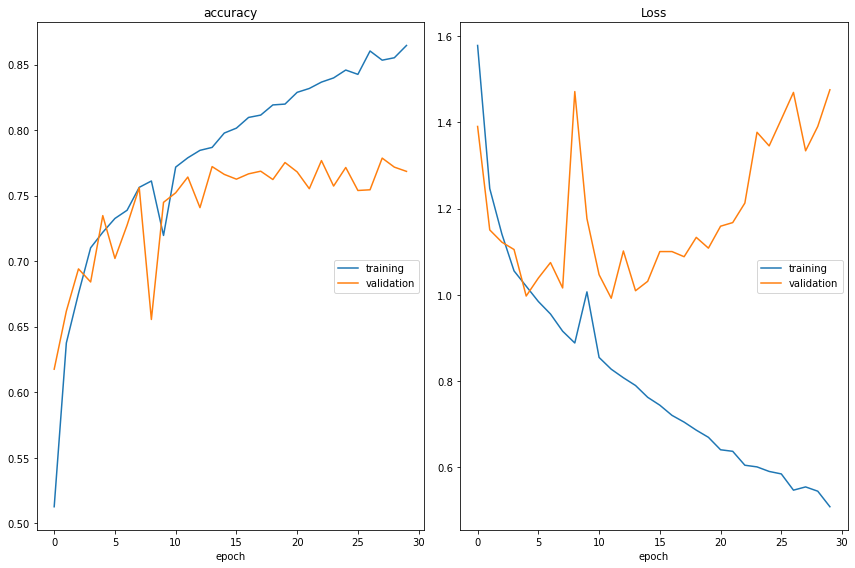

accuracy
	training         	 (min:    0.513, max:    0.865, cur:    0.865)
	validation       	 (min:    0.618, max:    0.779, cur:    0.768)
Loss
	training         	 (min:    0.508, max:    1.579, cur:    0.508)
	validation       	 (min:    0.992, max:    1.476, cur:    1.476)


True

In [15]:




# define two sets of inputs
inputA = Input(shape=(129,13,4))
inputB = Input(shape=(1499,3))
inputC = Input(shape=(6))
# the first branch operates on the first input

x = Conv2D(64, (7,7), strides =2 , padding='same', activation=tf.nn.relu,  input_shape=(129,13,4))(inputA)
x = Dropout(0.2)(x)
x =  Conv2D(64, (7,7), strides =2 , padding='same', activation=tf.nn.relu)(x)
x = MaxPooling2D((2,2), strides=2, data_format='channels_first')(x)
x = Conv2D(32, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(32, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(16, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(8, 5,padding='same', activation=tf.nn.relu)(x)
x = Dropout(0.1)(x)

x = Conv2D(8, 5,padding='same', activation=tf.nn.relu)(x)
x = Flatten()(x)
"""
x= Dense(200, activation=tf.nn.leaky_relu)(x)
x= Dense(100, activation=tf.nn.leaky_relu)(x)
x= Dense(5, activation="linear")(x)"""

x = Model(inputs=inputA, outputs=x)
#x.summary()
# the second branch opreates on the second input
y = Conv1D(3,10, strides=10,activation=tf.nn.leaky_relu)(inputB)
y = Conv1D(2,5, strides =5, activation=tf.nn.leaky_relu)(y)
y = Dropout(0.1)(y)
y = Conv1D(1,2 ,strides=2 ,activation=tf.nn.leaky_relu)(y)
y = Dropout(0.1)(y)
y = Flatten()(y)
"""
y = Dense(100, activation=tf.nn.leaky_relu)(y)
y= Dense(50, activation=tf.nn.leaky_relu)(y)
y= Dense(5, activation="linear")(y)"""

y = Model(inputs=inputB, outputs=y)
#y.summary()



k = Dense(6, activation=tf.nn.leaky_relu)(inputC)

k = Model(inputs=inputC, outputs=k)


# combine the output of the two branches
combined = concatenate([x.output, y.output, k.output])
#combined =concatenate(
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(200, activation=tf.nn.leaky_relu)(combined)

z = Dense(150, activation=tf.nn.leaky_relu)(z)
z= Dropout(0.1)(z)
z = Dense(100, activation=tf.nn.leaky_relu)(z)
z = Dense(5, activation="softmax")(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input, k.input], outputs=z)

#model.summary()


model.compile(optimizer='adam', 
              loss=custom_loss,
              metrics=['accuracy'])


model.summary()

model.fit([x_train_eeg,x_train_mvt, meta_train], y_train,
          epochs=30,
          validation_data=([x_validation_eeg, x_validation_mvt, meta_validation], y_validation),
          callbacks=[PlotLossesKeras()],
          verbose='verbose')
make_beep()




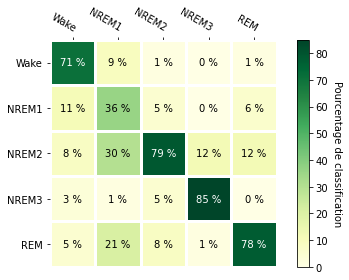

In [16]:
y_estimate =np.argmax( model.predict([x_validation_eeg,x_validation_mvt, meta_validation]), axis=1)
plot_heatmap(y_validation, y_estimate)

#### For save the data

In [17]:

x_test = extract_testset(input_signals_list, mean_mvt , var_mvt,mean_eeg, var_eeg, spoc )
save_submission(x_test)

(24980, 1500, 10)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


True

## Around 74%


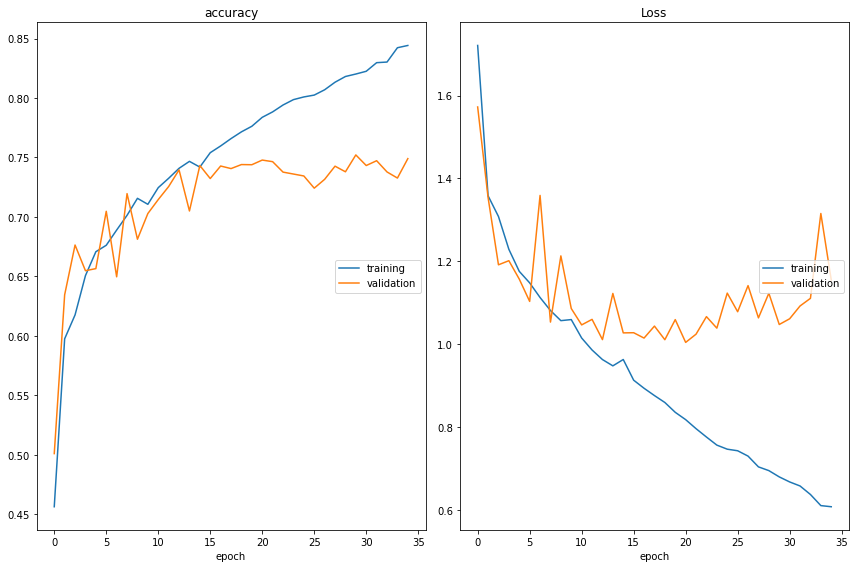

accuracy
	training         	 (min:    0.456, max:    0.844, cur:    0.844)
	validation       	 (min:    0.501, max:    0.752, cur:    0.749)
Loss
	training         	 (min:    0.608, max:    1.721, cur:    0.608)
	validation       	 (min:    1.004, max:    1.572, cur:    1.155)


True

In [19]:




# define two sets of inputs
inputA = Input(shape=(129,13,4))
inputB = Input(shape=(1499,3))
# the first branch operates on the first input

x = Conv2D(64, (7,7), strides =2 , padding='same', activation=tf.nn.relu,  input_shape=(129,13,4))(inputA)
x = Dropout(0.2)(x)
x =  Conv2D(64, (7,7), strides =2 , padding='same', activation=tf.nn.relu,  input_shape=(129,13,4))(x)
x = MaxPooling2D((2,2), strides=2, data_format='channels_first')(x)
x = Conv2D(32, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(32, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(16, 5,padding='same', activation=tf.nn.relu)(x)
x = Conv2D(8, 5,padding='same', activation=tf.nn.relu)(x)
x = Dropout(0.1)(x)

x = Conv2D(8, 5,padding='same', activation=tf.nn.relu)(x)
x = Flatten()(x)

x= Dense(200, activation=tf.nn.leaky_relu)(x)
x= Dense(100, activation=tf.nn.leaky_relu)(x)
x= Dense(5, activation="linear")(x)

x = Model(inputs=inputA, outputs=x)
#x.summary()
# the second branch opreates on the second input
y = Conv1D(3,10, strides=10,activation=tf.nn.leaky_relu)(inputB)
y = Conv1D(2,5, strides =5, activation=tf.nn.leaky_relu)(y)
y = Dropout(0.1)(y)
y = Conv1D(1,2 ,strides=2 ,activation=tf.nn.leaky_relu)(y)
y = Dropout(0.1)(y)
y = Flatten()(y)

y = Dense(100, activation=tf.nn.leaky_relu)(y)
y= Dense(50, activation=tf.nn.leaky_relu)(y)
y= Dense(5, activation=tf.nn.leaky_relu)(y)

y = Model(inputs=inputB, outputs=y)
#y.summary()
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs

z = Dense(150, activation=tf.nn.leaky_relu)(combined)
z= Dropout(0.1)(z)
z = Dense(100, activation=tf.nn.leaky_relu)(z)
z = Dense(5, activation="softmax")(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

#model.summary()


model.compile(optimizer='adam', 
              loss=custom_loss,
              metrics=['accuracy'])


model.summary()

model.fit([x_train_eeg,x_train_mvt], y_train,
          epochs=35,
          validation_data=([x_validation_eeg, x_validation_mvt], y_validation),
          callbacks=[PlotLossesKeras()],
          verbose='verbose')
make_beep()






In [ ]:
y_estimate =np.argmax( model.predict([x_validation_eeg,x_validation_mvt]), axis=1)
plot_heatmap(y_validation, y_estimate)
y_estimate =np.argmax( model.predict([x_train_eeg,x_train_mvt]), axis=1)
plot_heatmap(y_train, y_estimate)



### How we decide our custom weigths for loss

In [ ]:
occurence = np.zeros((5))
for i in range(5):
    occurence[i]= np.sum(np.where(y_train == i))
print(occurence)
plt.bar([1,2,3,4,5] , occurence )

weight =occurence/sum(occurence)
print(1- weight)

In [ ]:
weight = - np.log( occurence/sum(occurence))


### Test for the positional embeding with sigmoid

In [ ]:
y_binary_train = np.where(np.logical_and(y_train == 0, y_train ==1) , 0, 1 )
y_binary_validation = np.where(np.logical_and(y_train == 0, y_train ==1), 0, 1 )


In [ ]:


inputC = Input(shape=(6))

k = Dense(6, activation=tf.nn.leaky_relu)(inputC)
k = Dense(6, activation=tf.nn.leaky_relu)(k)
k = Dense(1, activation="sigmoid")(k)
model = Model(inputs=inputC, outputs=k)


# combine the output of the two branches
#combined =concatenate(
# apply a FC layer and then a regression prediction on the
# combined outputs


# our model will accept the inputs of the two branches and
# then output a single value

#model.summary()


model.compile(optimizer='SGD', 
              loss='BinaryCrossentropy',
              metrics=['accuracy'])


model.summary()

model.fit([ meta_train], y_binary_train,
          epochs=60,
          validation_data=([ meta_validation], y_binary_validation),
          callbacks=[PlotLossesKeras()],
          verbose='verbose')
make_beep()


In [ ]:
y_estimate =np.argmax( model.predict([meta_validation]), axis=1)
plot_heatmap(y_validation, y_estimate)